# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [259]:
# Parameters
m = 1
A = 0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [260]:
res=m;
N=2.0^m*500#1000.0#2.0^m*1000.0;#2.0^m*500.0;#N=2.0^m*500.0#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx,digits=10);
Nt=2.0^m*500.0#100.0*2^m*10
Tf=Nt*dt; #final time
print(Tf)

1.0

In [261]:
print(N)

1000.0

In [262]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)

dx =0.001
dt =0.001
dx/dt =1.0


In [263]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [264]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [265]:
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
#T=range(0,stop=Tf,step=dt)
println("the time step is ", dt)

step size is  0.001
the time step is 0.001


In [266]:
include("./ScalarField.jl");

# Initial data of m β Ψ and Ψ,x

In [267]:
using PyCall   
using Interpolations
using TickTock
using Dierckx

tick()
scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####


psi_func = Spline1D(initX[4:L-3], state_array[4:L-3,3],  k=4)
derpsi_func = Spline1D(initX[4:L-3], initderpsi[4:L-3],  k=4)#new

funcs = [psi_func, derpsi_func];

tock()

[ Info:  started timer at: 2023-04-12T12:49:33.664
[ Info:          0.229759642s: 229 milliseconds


In [268]:
#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,initX1,0,funcs)
state_array[:,2]=initbeta;
state_array=ghost(state_array);


#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,initX1,0,funcs)
state_array[:,1]=initm;
state_array = ghost(state_array);

In [269]:
"""using Plots #showing initial data and the initial status of the horizon finder
plot(initX, state_array[:,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])"""

"using Plots #showing initial data and the initial status of the horizon finder\nplot(initX, state_array[:,1:4], xaxis=\"x\",title=\"Initial Data\", labels=[\"m\" \"beta\" \"psi\" \"psi,x\"])"

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [270]:
using CSV, Tables
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

In [271]:
time=0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
monitor_ratio = zeros(L)
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [272]:
ginit=dt_scale(initX,state_array[:,1],state_array[:,2],dx)
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

1.0


 ## Time evolution

fixed grid

In [273]:
finaltime=1.1#0.8#0.04*5*4#length(T)-1
evol_stats, T_interp = timeevolution(state_array,finaltime,dir*"/res$res",run);
CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);

iteration 10 dt is 0.001, time of iteration is 0.010000000000000002
iteration 20 dt is 0.001, time of iteration is 0.02000000000000001
iteration 30 dt is 0.001, time of iteration is 0.03000000000000002
iteration 40 dt is 0.001, time of iteration is 0.04000000000000003
iteration 50 dt is 0.001, time of iteration is 0.05000000000000004
iteration 60 dt is 0.001, time of iteration is 0.060000000000000046
iteration 70 dt is 0.001, time of iteration is 0.07000000000000005
iteration 80 dt is 0.001, time of iteration is 0.08000000000000006
iteration 90 dt is 0.001, time of iteration is 0.09000000000000007
iteration 100 dt is 0.001, time of iteration is 0.10000000000000007
iteration 110 dt is 0.001, time of iteration is 0.11000000000000008
iteration 120 dt is 0.001, time of iteration is 0.12000000000000009
iteration 130 dt is 0.001, time of iteration is 0.1300000000000001
iteration 140 dt is 0.001, time of iteration is 0.1400000000000001
iteration 150 dt is 0.001, time of iteration is 0.1500000

 ## Movie of the evolution

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
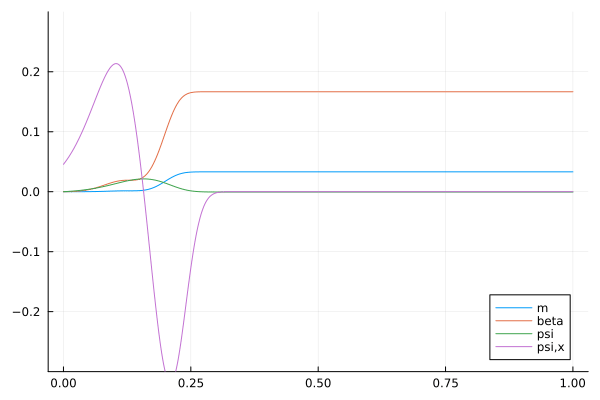

In [275]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 600:20:1010#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-0.3,0.3])#, xlim=[0, 0.1]) |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1)

In [69]:
dir

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"